# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### Apartado 1: Implementación mediante Q-Learning

In [545]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [546]:
# Leer el mapa
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz).T,(int(numeros[0]),int(numeros[1]))

mapa,destino = lee_mapa("map.txt")

In [547]:
# Parámetros del entorno
n,m = mapa.shape
Perror = 0.1  # Probabilidad de error en el movimiento
print(m,n)

15 51


In [548]:
# Posiciones inicial y final
Pinit = np.random.randint(n),np.random.randint(m)
while mapa[Pinit] == 1 or Pinit == destino:
    Pinit = np.random.randint(n),np.random.randint(m)
Pend = (destino[0], destino[1])

print("Posición inicial:", Pinit)
print("Posición final:", Pend)

Posición inicial: (44, 3)
Posición final: (40, 7)


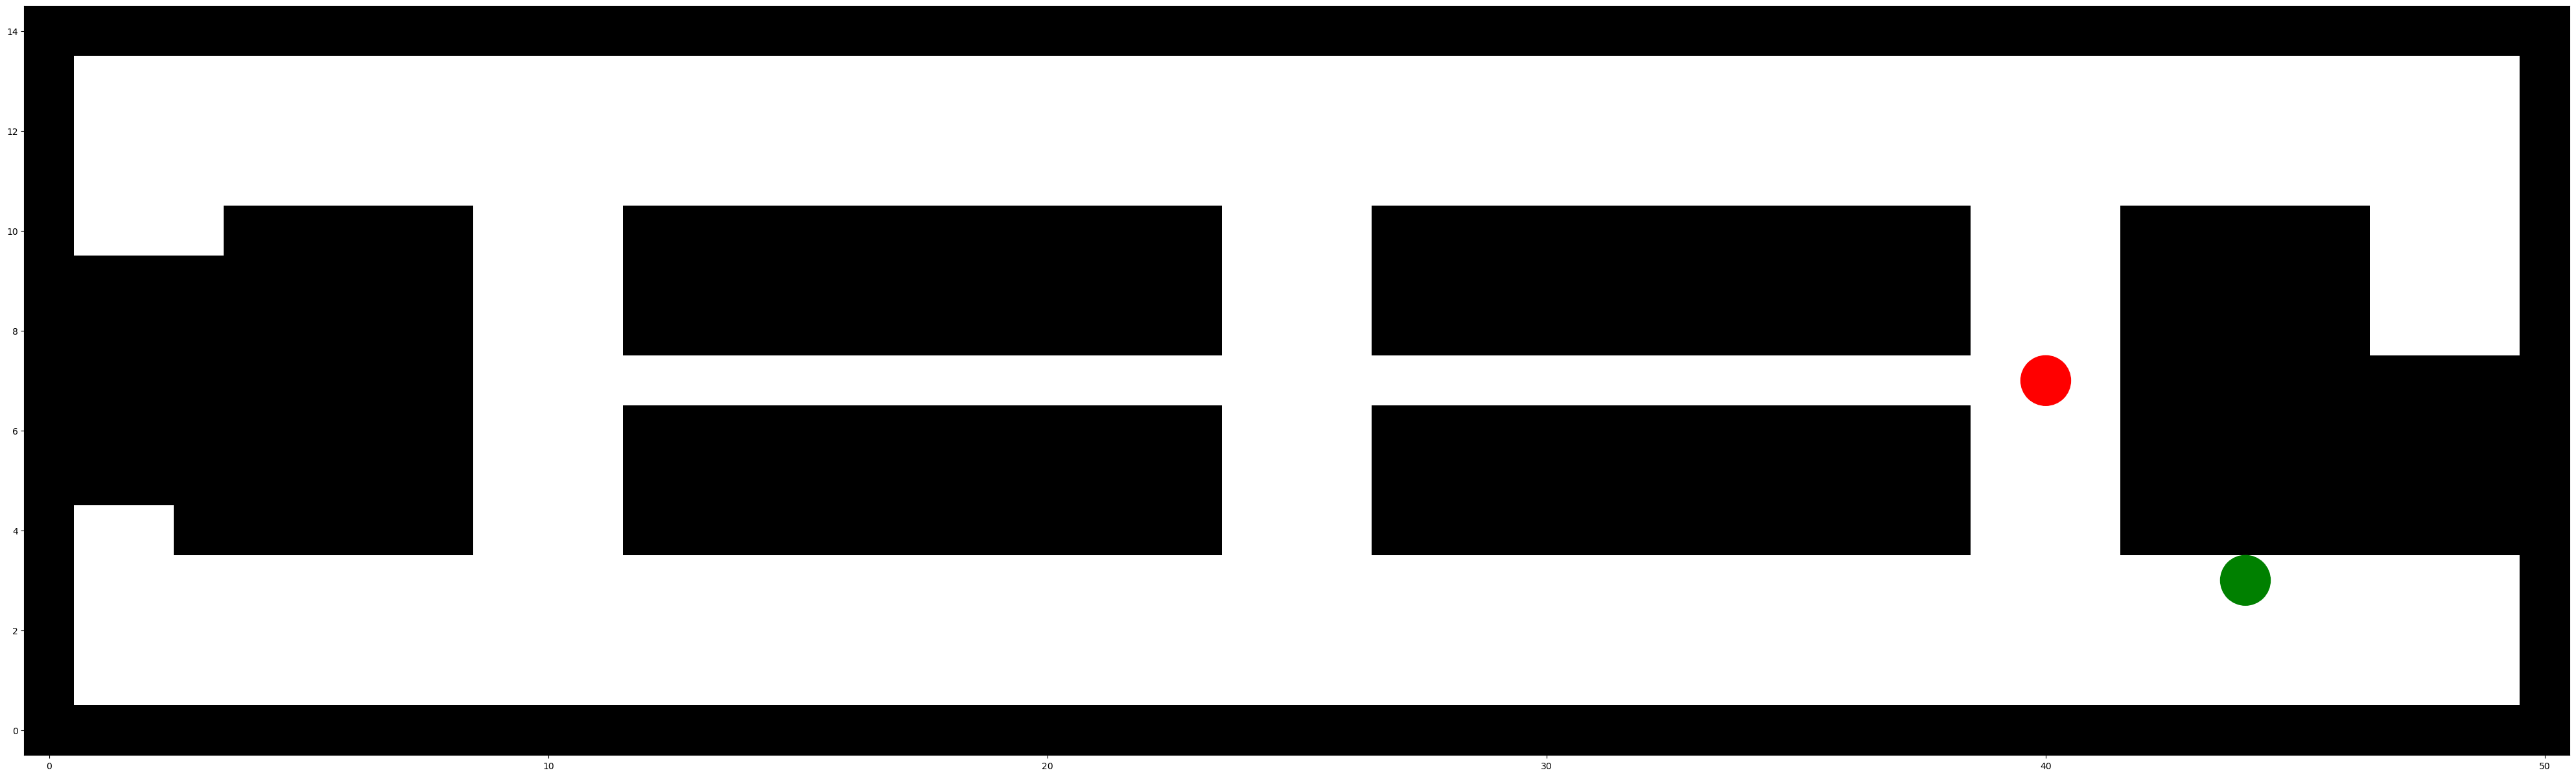

In [549]:
def visualiza_mapa():
    mapa_visual = np.copy(mapa).T
    plt.figure(figsize=(len(mapa_visual[0]), len(mapa_visual)))
    plt.imshow(1-mapa_visual, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa_visual[0]) - 0.5)
    plt.ylim(-0.5, len(mapa_visual) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
    plt.gca().add_patch(plt.Circle(Pinit,radius = 0.5,edgecolor = 'green', facecolor = 'green'))

visualiza_mapa()

In [550]:
def hay_colision(estado):
    return mapa[estado]==1

def aplica_accion(estado,accion):
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1

    # Verificar límites del mapa
    if x < 0 or x >= mapa.shape[0] or y < 0 or y >= mapa.shape[1] or hay_colision((x, y)):
        return estado
    return (x,y)

In [551]:
# Función de recompensa
K1 = -100
K2 = -1000
def obtiene_recompensa(estado):
    if hay_colision(estado):
        valor = K2
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

In [552]:
nav_estados = []
for i in range(0,mapa.shape[0]):
    for j in range(0,mapa.shape[1]):
        nav_estados.append(tuple([i,j]))
nav_estados

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 0),
 (7, 1),
 (

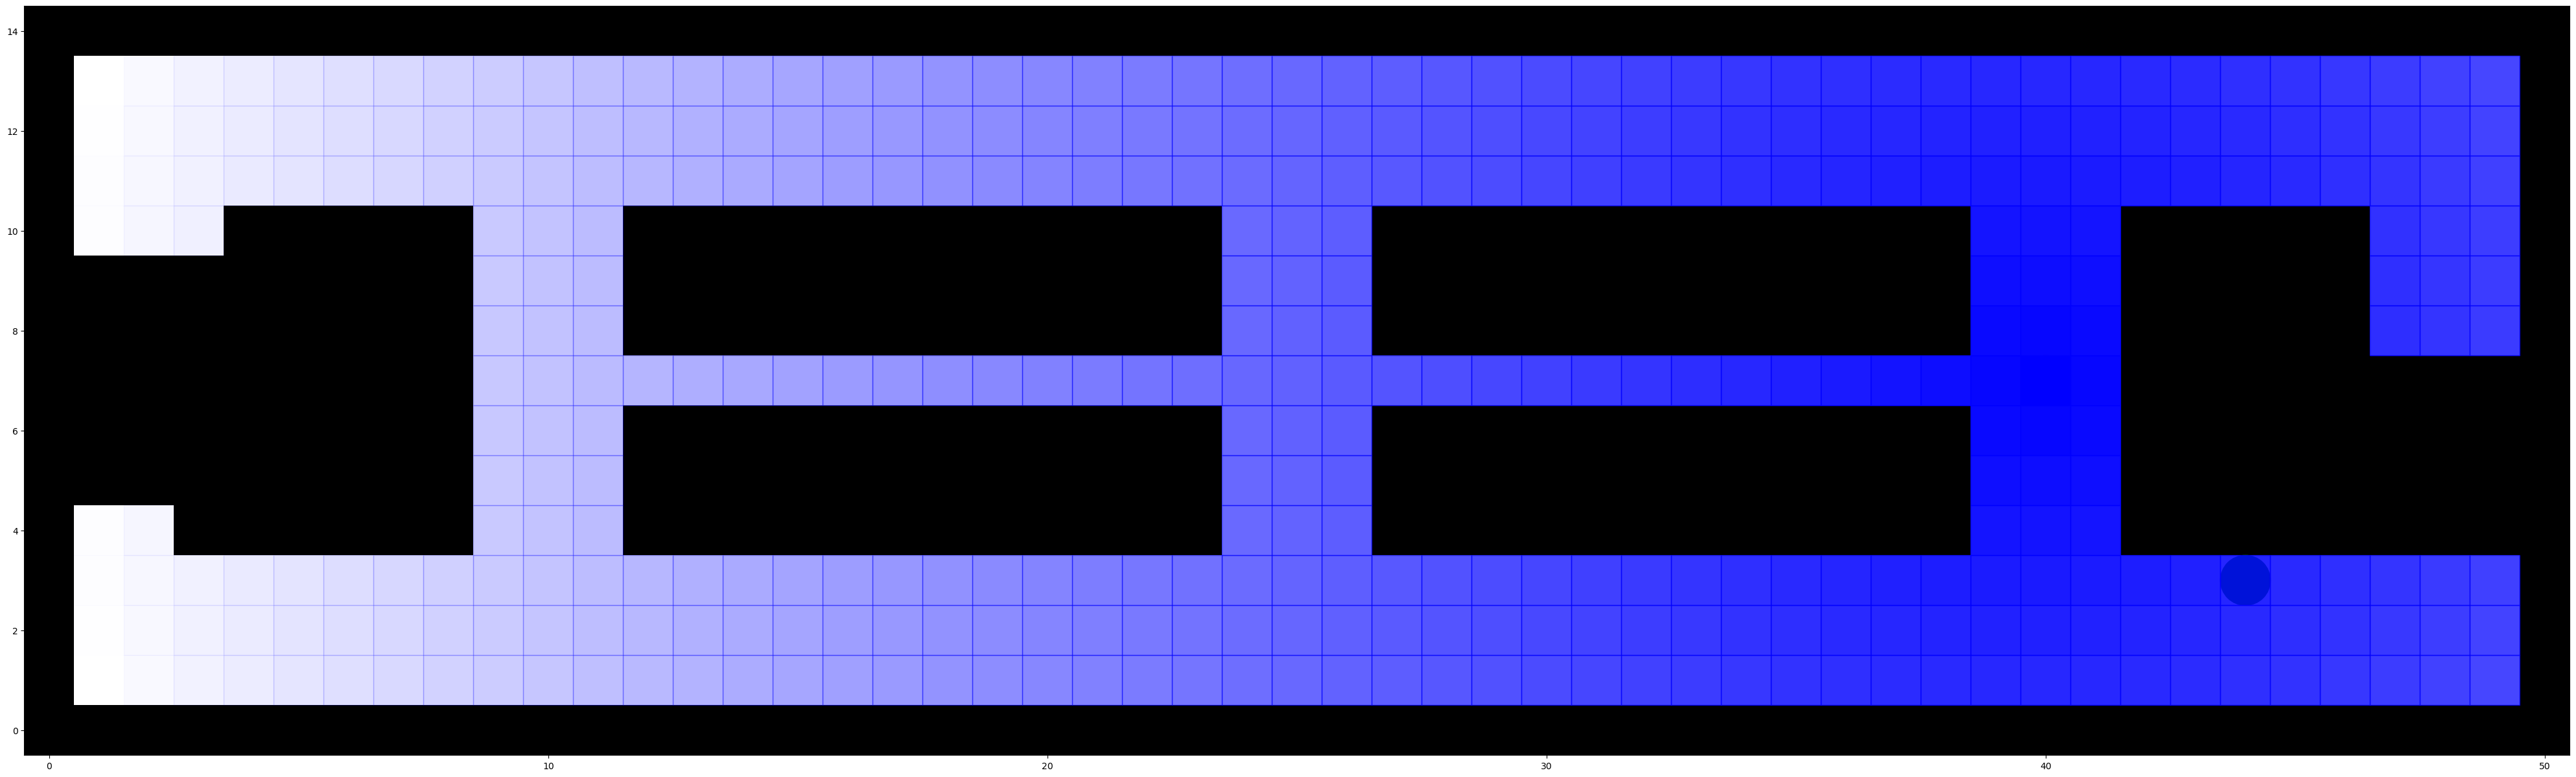

In [553]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa(e) for e in nav_estados]
    recompensas = [np.nan if elemento == -1000 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa(e)
        if r == -1000:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)

visualiza_recompensas()

In [554]:
nav_acciones = ['wait','N','NE','E','SE','S','SO','O','NO']
def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        r = obtiene_recompensa(e)
        fila = [r]*len(nav_acciones)
        if e != destino:
            fila[0]=-100000
        matriz.append(fila)
    return np.array(matriz)
nav_recompensas_sistema = crea_recompensas_sistema()
print(nav_recompensas_sistema[17])

[-1.00000000e+05 -3.93192065e+01 -3.93192065e+01 -3.93192065e+01
 -3.93192065e+01 -3.93192065e+01 -3.93192065e+01 -3.93192065e+01
 -3.93192065e+01]


In [555]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[1]+estado[1])

In [556]:
def obtiene_posibles_errores(accion):
    if accion=='N':
        errores = ['NE','NO']
    elif accion=='S':
        errores = ['SE','SO']
    elif accion=='E':
        errores = ['NE','SE']
    elif accion=='O':
        errores = ['NO', 'SO']
    elif accion=='NE':
        errores = ['N','E']
    elif accion=='NO':
        errores = ['N','O']
    elif accion=='SE':
        errores = ['S','E']
    elif accion == 'SO':
        errores = ['S','O']
    else:
        errores = []
    return errores

In [560]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0] * len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)] = 1
        else:
            goal = aplica_accion(e0, accion)
            errores = obtiene_posibles_errores(accion)
            if len(errores) == 0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0, error)
                    fila[obtiene_indice_estado(goal_error)] += prob_error / len(errores)
        # Asegurar que la fila suma a 1
        suma_fila = sum(fila)
        if suma_fila != 1:
            fila = [x / suma_fila for x in fila]
        matriz.append(fila)
    return np.array(matriz)


In [561]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento('wait',prob_error), 
                     crea_transiciones_movimiento('N',prob_error),
                     crea_transiciones_movimiento('NE',prob_error),
                     crea_transiciones_movimiento('E',prob_error),
                     crea_transiciones_movimiento('SE',prob_error),
                     crea_transiciones_movimiento('S',prob_error),
                     crea_transiciones_movimiento('SO',prob_error),
                     crea_transiciones_movimiento('O',prob_error),
                     crea_transiciones_movimiento('NO',prob_error)])

nav_transiciones_sistema = crea_transiciones_sistema(Perror)

In [562]:
# Implementación de Q-Learning con mdptoolbox
ql = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.01, n_iter=300000)
ql.run()

In [563]:
print("Política óptima:")
print(ql.policy)
print(len(ql.policy))
print("Acciones" + str(nav_acciones))

# Visualización de la política óptima
i = 0
for action in ql.policy:
    print("Decisión en el estado ", i, "( " + str(i // m) + ", " + str(i % m) + "): ", nav_acciones[action])
    i+=1


Política óptima:
(1, 1, 2, 6, 7, 1, 6, 6, 1, 5, 3, 2, 7, 3, 4, 8, 2, 3, 1, 2, 8, 1, 2, 2, 1, 8, 2, 2, 7, 1, 4, 6, 6, 5, 4, 2, 4, 8, 8, 1, 2, 1, 1, 6, 3, 4, 2, 1, 5, 1, 6, 6, 3, 5, 1, 8, 6, 1, 3, 1, 5, 4, 1, 1, 1, 1, 5, 6, 3, 7, 7, 1, 1, 8, 1, 3, 7, 8, 3, 8, 1, 2, 4, 8, 8, 0, 8, 2, 1, 7, 1, 7, 3, 8, 4, 3, 7, 8, 8, 2, 5, 1, 8, 5, 2, 7, 4, 6, 4, 8, 3, 6, 4, 7, 1, 2, 1, 7, 6, 4, 6, 4, 3, 2, 7, 2, 5, 7, 6, 1, 2, 7, 2, 6, 8, 5, 8, 3, 4, 4, 5, 2, 7, 1, 4, 4, 5, 8, 6, 5, 2, 8, 1, 7, 4, 3, 1, 5, 2, 4, 7, 7, 5, 3, 2, 5, 1, 5, 3, 4, 2, 4, 5, 6, 6, 1, 4, 8, 7, 6, 5, 7, 6, 8, 4, 8, 2, 1, 6, 4, 2, 4, 2, 1, 7, 8, 5, 2, 5, 7, 8, 2, 4, 2, 0, 2, 4, 1, 6, 0, 1, 5, 4, 1, 3, 6, 6, 6, 4, 7, 3, 4, 2, 5, 1, 2, 8, 8, 6, 6, 6, 5, 3, 5, 5, 8, 8, 8, 3, 2, 2, 6, 3, 2, 2, 2, 6, 6, 3, 6, 6, 5, 6, 6, 1, 2, 5, 6, 2, 6, 2, 2, 4, 4, 7, 7, 2, 1, 1, 4, 8, 8, 5, 8, 7, 4, 4, 5, 5, 8, 8, 7, 3, 1, 4, 1, 8, 4, 7, 3, 3, 5, 5, 4, 5, 1, 6, 5, 2, 7, 7, 2, 5, 4, 3, 1, 2, 3, 6, 5, 6, 8, 3, 4, 7, 2, 8, 7, 7, 6, 2, 2, 2, 5, 8, 4, 4, 7

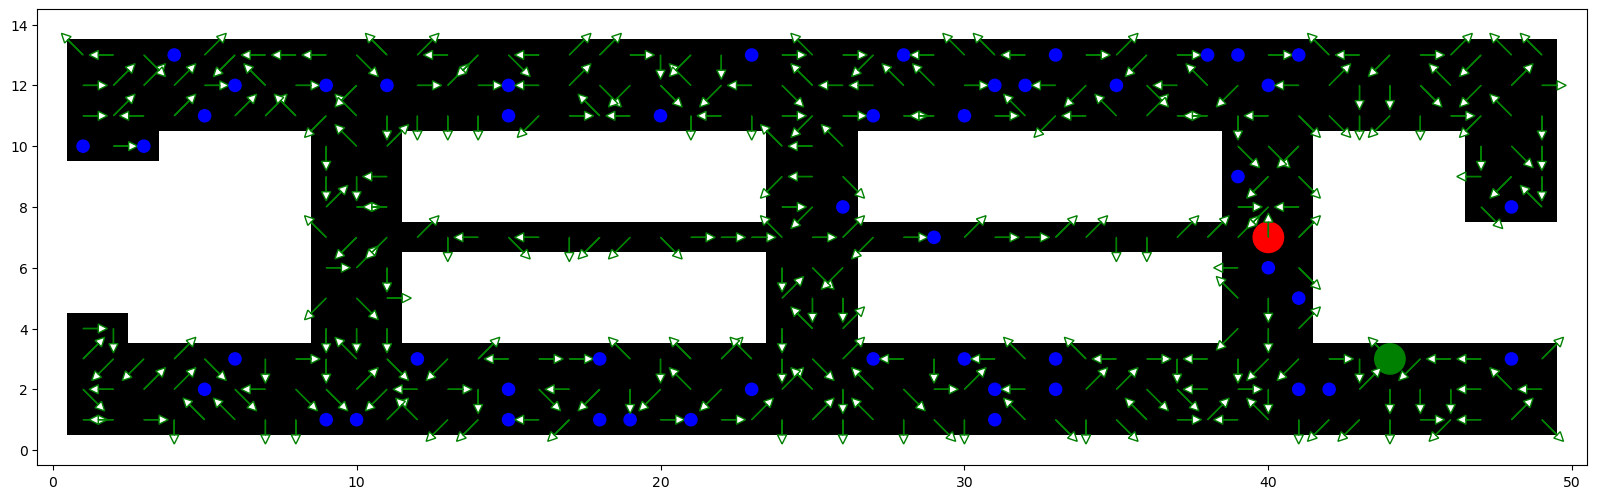

In [564]:
# Definir un diccionario para mapear índices de acciones a desplazamientos
movimientos = {
    'n': (0, 1), 'ne': (1, 1), 'e': (1, 0), 'se': (1, -1),
    's': (0, -1), 'sw': (-1, -1), 'w': (-1, 0), 'nw': (-1, 1), 'wait': (0, 0)
}

# Lista de acciones
acciones = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'wait']

def aplica_accion(estado, accion):
    mov = movimientos[accion]
    return (estado[0] + mov[0], estado[1] + mov[1])

def visualiza_mapa():
    plt.figure(figsize=(20, 20))
    plt.imshow(mapa.T, cmap='gray', origin='lower')
    plt.gca().add_patch(plt.Circle((destino), radius=0.5, edgecolor='red', facecolor='red'))
    plt.gca().add_patch(plt.Circle((Pinit), radius=0.5, edgecolor='green', facecolor='green'))

def visualiza_politica(politica):
    visualiza_mapa()
    for i in range(n):
        for j in range(m):
            if mapa[i, j] == 0:
                s_index = i * m + j
                accion = acciones[politica[s_index]].lower()
                if accion == 'wait':
                    plt.gca().add_patch(plt.Circle((i,j), radius=0.2, edgecolor='blue', facecolor='blue'))
                    continue
                estado = (i, j)
                e1 = aplica_accion(estado, accion)
                x0, y0 = estado[0], estado[1]
                x1, y1 = e1[0], e1[1]

                plt.gca().arrow(x0, y0, (x1 - x0) * 0.5, (y1 - y0) * 0.5, head_width=0.3, head_length=0.3, fc='white', ec='green')
    plt.show()
visualiza_politica(ql.policy)

In [568]:
i = 0
w = 0
for action in ql.policy:
    if(action == 8):
        w+=1
    i+=1

print("Fin del programa: " + str(i) + " estados")
print("Esperar: " + str(w) + " veces")

Fin del programa:765 estados
Esperar:94 veces


In [544]:
# Probar la función aplica_accion con algunos ejemplos
estados_prueba = [(4, 1), (4, 2), (5, 1), (5, 2)]
acciones_prueba = ['N', 'S', 'E', 'O', 'NE', 'SE', 'SO', 'NO']
for estado in estados_prueba:
    for accion in acciones_prueba:
        nuevo_estado = aplica_accion(estado, accion)
        print(f"Estado: {estado}, Acción: {accion}, Nuevo Estado: {nuevo_estado}")

Estado: (4, 1), Acción: N, Nuevo Estado: (4, 2)
Estado: (4, 1), Acción: S, Nuevo Estado: (4, 1)
Estado: (4, 1), Acción: E, Nuevo Estado: (5, 1)
Estado: (4, 1), Acción: O, Nuevo Estado: (3, 1)
Estado: (4, 1), Acción: NE, Nuevo Estado: (5, 2)
Estado: (4, 1), Acción: SE, Nuevo Estado: (4, 1)
Estado: (4, 1), Acción: SO, Nuevo Estado: (4, 1)
Estado: (4, 1), Acción: NO, Nuevo Estado: (3, 2)
Estado: (4, 2), Acción: N, Nuevo Estado: (4, 3)
Estado: (4, 2), Acción: S, Nuevo Estado: (4, 1)
Estado: (4, 2), Acción: E, Nuevo Estado: (5, 2)
Estado: (4, 2), Acción: O, Nuevo Estado: (3, 2)
Estado: (4, 2), Acción: NE, Nuevo Estado: (5, 3)
Estado: (4, 2), Acción: SE, Nuevo Estado: (5, 1)
Estado: (4, 2), Acción: SO, Nuevo Estado: (3, 1)
Estado: (4, 2), Acción: NO, Nuevo Estado: (3, 3)
Estado: (5, 1), Acción: N, Nuevo Estado: (5, 2)
Estado: (5, 1), Acción: S, Nuevo Estado: (5, 1)
Estado: (5, 1), Acción: E, Nuevo Estado: (6, 1)
Estado: (5, 1), Acción: O, Nuevo Estado: (4, 1)
Estado: (5, 1), Acción: NE, Nuev

In [542]:
# Verificación de las recompensas
print("Verificación de recompensas:")
for estado in nav_estados[60:80]:
    print(f"Estado: {estado}, Recompensa: {obtiene_recompensa(estado)}")

# Verificación de las transiciones
print("\nVerificación de transiciones:")
for i, accion in enumerate(nav_acciones[:3]):
    print(f"\nAcción: {accion}")
    transiciones = nav_transiciones_sistema[i]
    for j in range(5):
        print(f"Desde estado {nav_estados[j]} a {np.where(transiciones[j] > 0)} con probabilidad {transiciones[j, np.where(transiciones[j] > 0)]}")

# Verificación de la política resultante
print("\nVerificación de la política resultante:")
for i in range(10):
    estado = nav_estados[i]
    accion = nav_acciones[ql.policy[i]]
    print(f"Estado: {estado}, Acción: {accion}")


Verificación de recompensas:
Estado: (4, 0), Recompensa: -1000
Estado: (4, 1), Recompensa: -36.49657518178932
Estado: (4, 2), Recompensa: -36.345563690772494
Estado: (4, 3), Recompensa: -36.22154055254967
Estado: (4, 4), Recompensa: -1000
Estado: (4, 5), Recompensa: -1000
Estado: (4, 6), Recompensa: -1000
Estado: (4, 7), Recompensa: -1000
Estado: (4, 8), Recompensa: -1000
Estado: (4, 9), Recompensa: -1000
Estado: (4, 10), Recompensa: -1000
Estado: (4, 11), Recompensa: -36.22154055254967
Estado: (4, 12), Recompensa: -36.345563690772494
Estado: (4, 13), Recompensa: -36.49657518178932
Estado: (4, 14), Recompensa: -1000
Estado: (5, 0), Recompensa: -1000
Estado: (5, 1), Recompensa: -35.510561809129406
Estado: (5, 2), Recompensa: -35.35533905932738
Estado: (5, 3), Recompensa: -35.22782990761707
Estado: (5, 4), Recompensa: -1000

Verificación de transiciones:

Acción: wait
Desde estado (0, 0) a (array([0], dtype=int64),) con probabilidad [[1.]]
Desde estado (0, 1) a (array([1], dtype=int64),)